In [1]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from global_land_mask import globe

sys.path.insert(0,'/home/cameron/Projects/')

In [2]:
points_file = '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-bin3.points'
nc_file = '/home/cameron/Dokumenter/Data/frohavet/frohavet_2023-03-29_1044Z-l1a.nc'
l1a_prefix = nc_file.rsplit('-', maxsplit=1)[0]
l1a_file_prefix = l1a_prefix.split('/')[-1]

files = [points_file, nc_file] # List of files to be read by SatPy

# Create SatPy scene
scene = Scene(filenames=files, reader='hypso1_l1a_nc', reader_kwargs={'flip': True})


In [3]:
# Compute wl and choose bands for band ratio
spectral_coeffs = [ -5.719788129534360902e-09,
                    1.324037080791479811e-05, 
                    3.751455956374321055e-01,
                    2.264762366937773663e+02]
x_start = 428
x_stop = 1508
image_width = 120

x = np.linspace(x_start, x_stop, image_width)

h1_wl = spectral_coeffs[3] + spectral_coeffs[2]*x + spectral_coeffs[1]*x*x + spectral_coeffs[0]*x*x*x


a = abs(h1_wl-549)
min_index = np.argmin(a)
band_549nm_name = 'band_' + str(min_index)

a = abs(h1_wl-663)
min_index = np.argmin(a)
band_663nm_name = 'band_' + str(min_index)

scene.load(['latitude', 'longitude', band_549nm_name, band_663nm_name])
#datasets = scene.available_dataset_names()
#scene.load(datasets)

print(band_549nm_name)
print(scene['band_46'].wavelength) # This does not match?

print(band_663nm_name)
print(scene['band_78'].wavelength) # This does not match?

band_46
550
band_78
662


In [4]:
# Get image dimensions
img_dims = scene['latitude'].shape

# Land mask
land_mask = np.zeros(img_dims, dtype=bool)

lats = scene['latitude'].data
lons = scene['longitude'].data

for x in range(0,img_dims[0]):
    for y in range(0,img_dims[1]):
        lat = lats[x][y]
        lon = lons[x][y]
        land_mask[x][y] = globe.is_land(lat, lon)

# Cloud mask
cloud_mask = np.zeros(img_dims, dtype=bool)

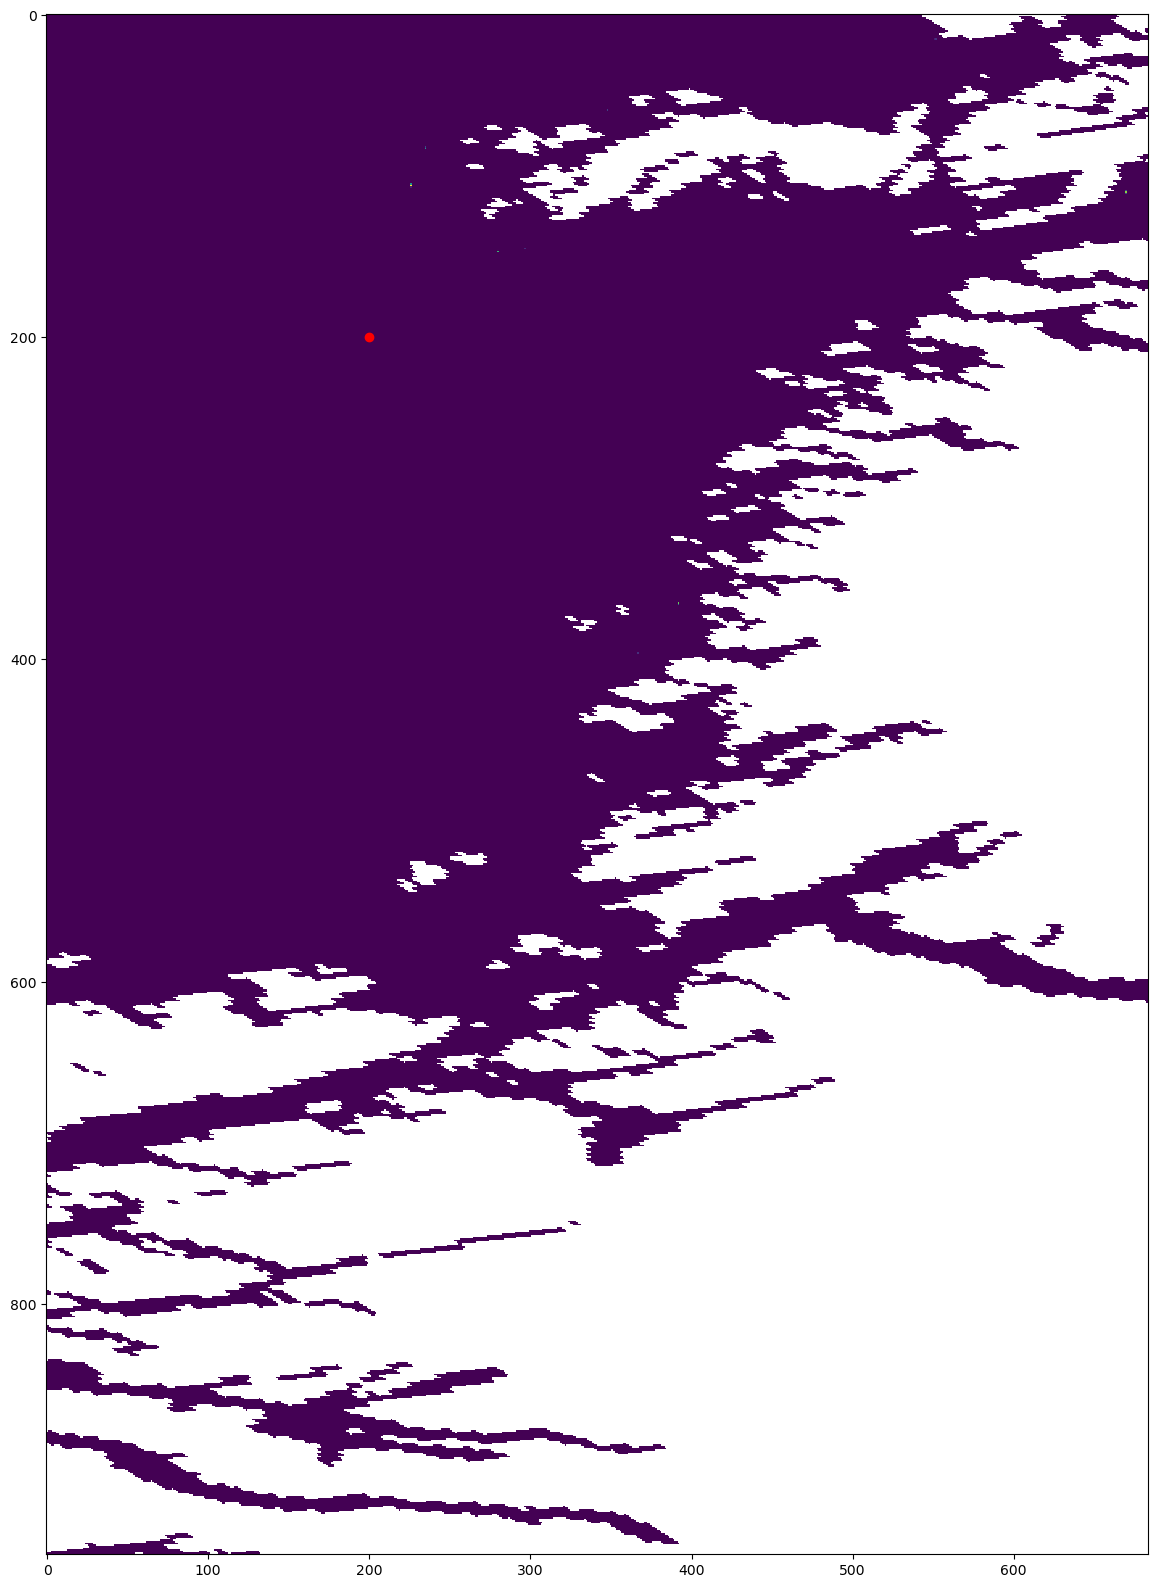

In [5]:
# Chlorophyll estimates
chlor = scene[band_549nm_name] / scene[band_663nm_name]
chlor = chlor.to_numpy()

chlor = np.ma.masked_array(chlor, land_mask, fill_value=np.nan)

#chlor = chlor - 0.6*chlor.compressed().max()
chlor = chlor - 0.88*chlor.compressed().max()
chlor[chlor < 0] = 0

chlor = chlor[:,::-1]

plt.figure(figsize=(20,20))
plt.imshow(chlor, interpolation='none')
plt.plot(200,200,'ro') 

# Concentration in units mg m-3

In [6]:
chlor[200,200]

0.0

In [8]:
coords = scene[band_549nm_name].coords

scene['chlor_a'] = xr.DataArray(chlor, coords=coords)
scene['chlor_a'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['chlor_a'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['chlor_a'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['chlor_a'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['chlor_a'].attrs['ancillary_variables'] = []

scene['land_mask'] = xr.DataArray(land_mask, coords=coords)
scene['land_mask'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['land_mask'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['land_mask'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['land_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['land_mask'].attrs['ancillary_variables'] = []

scene['cloud_mask'] = xr.DataArray(cloud_mask, coords=coords)
scene['cloud_mask'].attrs['area'] = scene[band_549nm_name].attrs['area']
scene['cloud_mask'].attrs['start_time'] = scene[band_549nm_name].attrs['start_time']
scene['cloud_mask'].attrs['end_time'] = scene[band_549nm_name].attrs['end_time']
scene['cloud_mask'].attrs['modifiers'] = satpy.dataset.dataid.ModifierTuple()
scene['cloud_mask'].attrs['ancillary_variables'] = []

scene.save_datasets(writer='cf', 
                    datasets=['chlor_a', 'land_mask', 'cloud_mask'], 
                    filename = './datasets_out/' + l1a_file_prefix+'-chlor_a' + '.nc')

KeyError: "No dataset matching 'DataQuery(name='band_40')' found"